In [2]:
from SwissArmyKnife import ClickHouseClient
import pandas as pd
from StringIO import StringIO
from scipy.stats import mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
import requests
import logging

logger = logging.getLogger(__name__)

    
def execute_query(query,
                  cluster= 'hahn', 
                  alias = "*ch_public", 
                  token = '', 
                  timeout=600):
    #logger.info("Executing query: %s", query)
    proxy = "http://{}.yt.yandex.net".format(cluster)
    s = requests.Session()
    url = "{proxy}/query?database={alias}&password={token}".format(proxy=proxy, alias=alias, token=token)
    resp = s.post(url, data=query, timeout=timeout)
    if resp.status_code != 200:
        logger.error("Response status: %s", resp.status_code)
        logger.error("Response headers: %s", resp.headers)
        logger.error("Response content: %s", resp.content)
    resp.raise_for_status()
    rows = resp.content.strip()#.split('\n')
    #logger.info("Time spent: %s seconds, rows returned: %s", resp.elapsed.total_seconds(), len(rows))
    return rows
execute_query('SELECT now()')

'2019-11-15 19:24:11'

# All Services

PAID
groupA


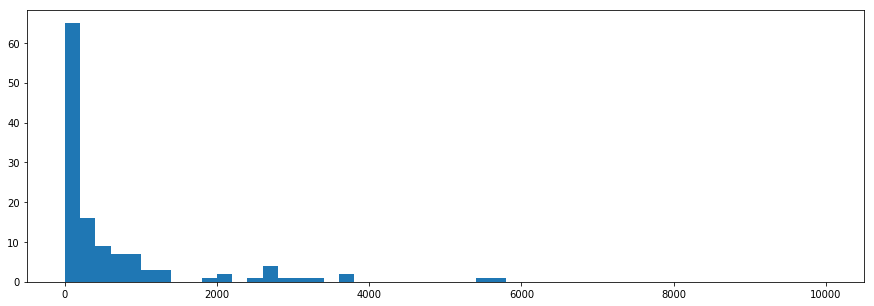

groupB


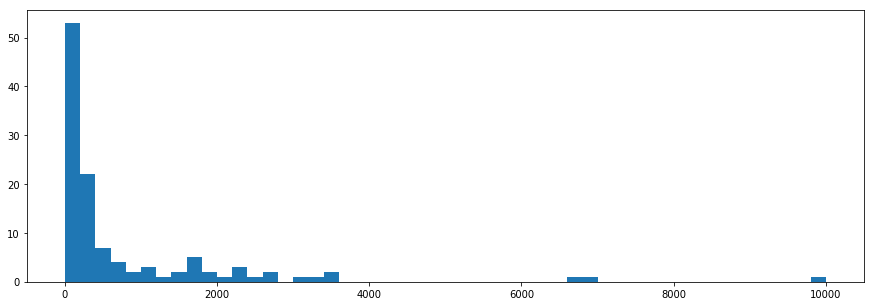

meanA: 842.08 meanB: 1086.71
nA: 126 nB: 118 mw: 6911.0 z: -0.95 mw_pvalue: 0.17
insignificant

TRIAL
groupA


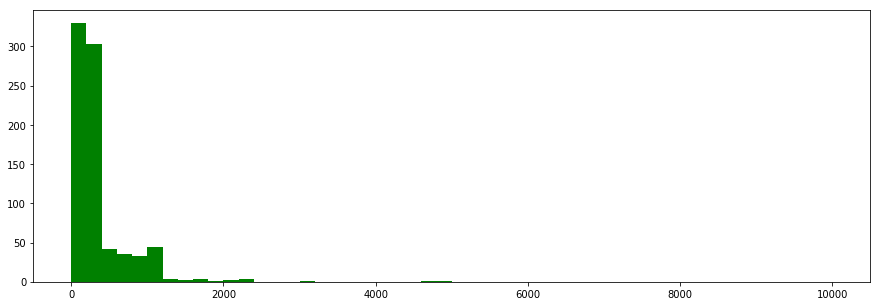

groupB


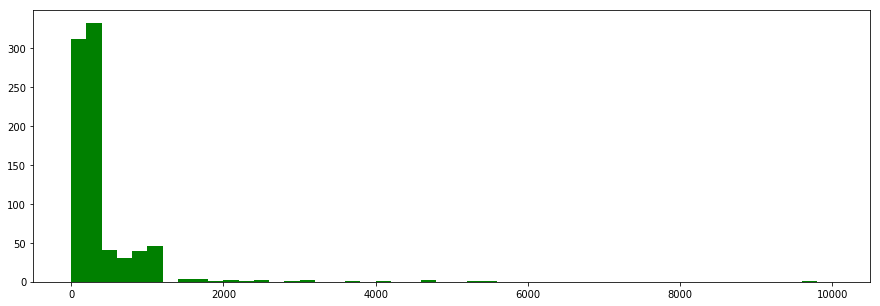

meanA: 362.1 meanB: 420.88
nA: 807 nB: 824 mw: 322539.0 z: -1.05 mw_pvalue: 0.15
insignificant
TOTAL
groupA


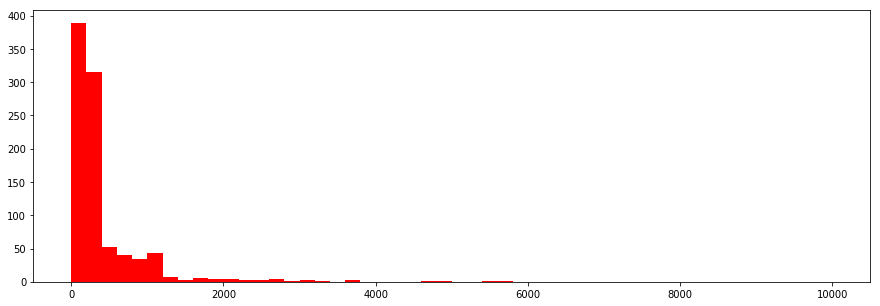

groupB


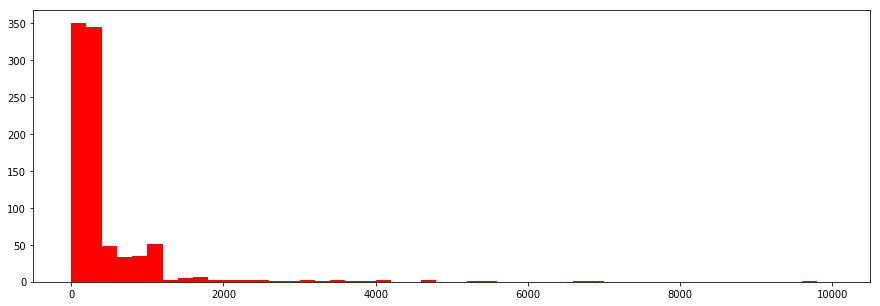

meanA: 432.95 meanB: 519.16
nA: 920 nB: 915 mw: 406411.5 z: -1.28 mw_pvalue: 0.1
insignificant


In [6]:
q = """
SELECT 
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
     billing_account_id,
     sum(trial_consumption) as trial,
     sum(real_consumption) as paid
FROM
     "//home/cloud_analytics/cubes/acquisition_cube/cube" as a GLOBAL INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as b 
USING puid
WHERE 
    event = 'day_use'
    and ba_usage_status != 'service'
    and toDate(event_time)>='2019-11-01'
    and sku_lazy = 0
    --and service_name = 'compute'
    --and subservice_name = 'cpu' 
    and segment = 'mass'
GROUP BY 
    group,
    billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'trial', 'paid'])

print 'PAID'
df1 = df[(df['group'] == 'groupA') & (df['paid'] > 0)]['paid'] 
df2 = df[(df['group'] == 'groupB') & (df['paid'] > 0)]['paid']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,10000))
plt.show()


n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print ''

print 'TRIAL'
df1 = df[(df['group'] == 'groupA') & (df['trial'] > 0)]['trial'] 
df2 = df[(df['group'] == 'groupB') & (df['trial'] > 0)]['trial']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'green')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'green')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print 'TOTAL'
df1 = df[(df['group'] == 'groupA')]['trial'] + df[(df['group'] == 'groupA')]['paid']
df2 = df[(df['group'] == 'groupB')]['trial'] + df[(df['group'] == 'groupB')]['paid']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'red')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'red')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# Compute

PAID
groupA


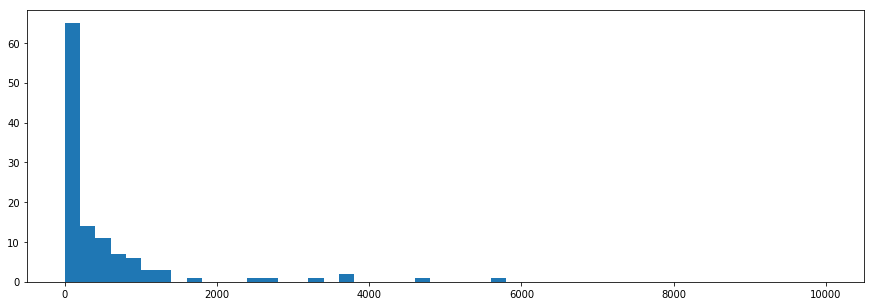

groupB


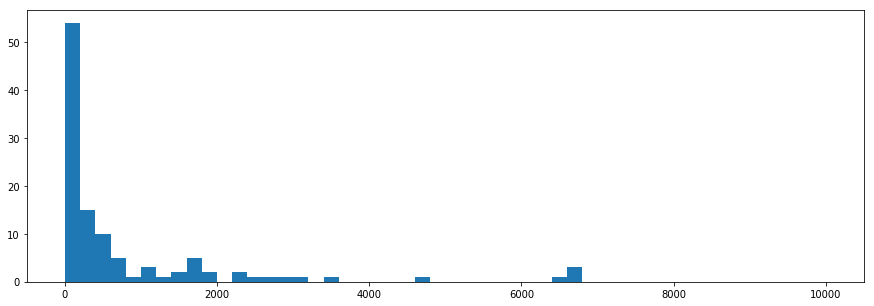

meanA: 728.17 meanB: 781.26
nA: 118 nB: 110 mw: 5942.0 z: -1.1 mw_pvalue: 0.14
insignificant

TRIAL
groupA


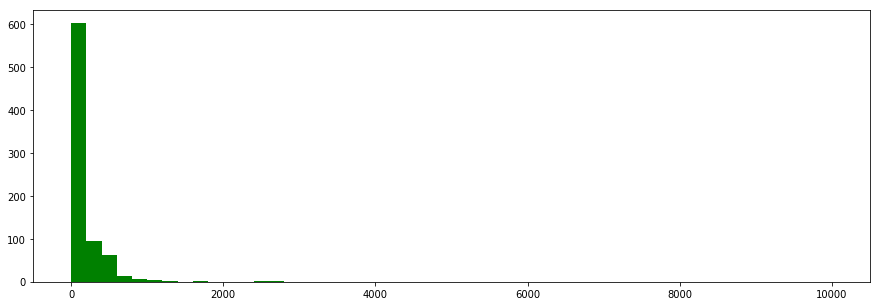

groupB


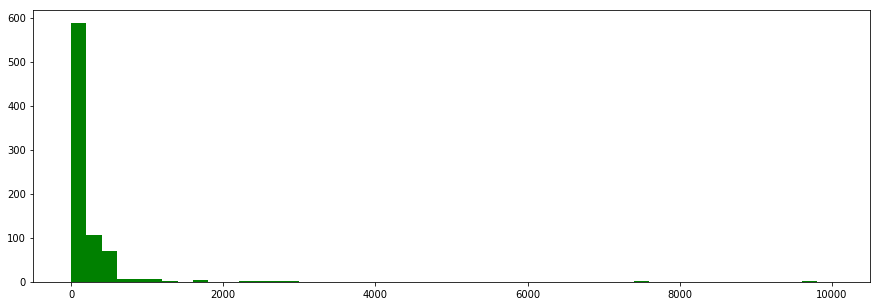

meanA: 176.16 meanB: 220.36
nA: 789 nB: 797 mw: 297334.0 z: -1.87 mw_pvalue: 0.03
significant
TOTAL
groupA


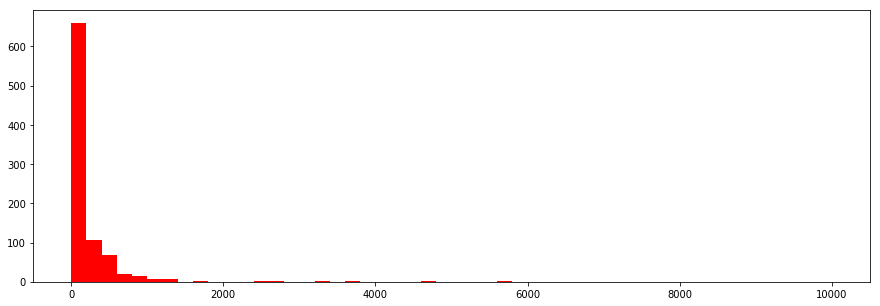

groupB


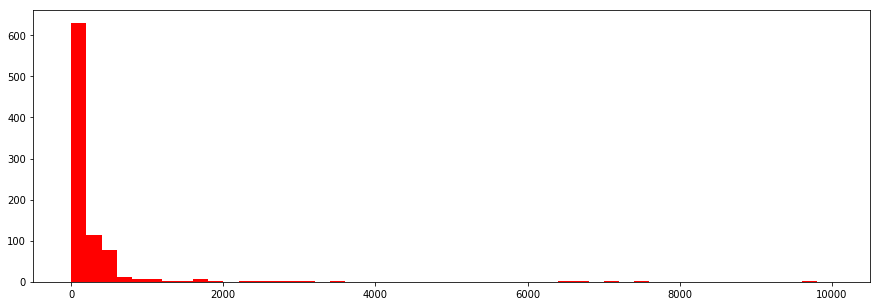

meanA: 251.02 meanB: 295.22
nA: 896 nB: 886 mw: 374878.0 z: -2.03 mw_pvalue: 0.02
significant


In [7]:
q = """
SELECT 
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
     billing_account_id,
     sum(trial_consumption) as trial,
     sum(real_consumption) as paid
FROM
     "//home/cloud_analytics/cubes/acquisition_cube/cube" as a GLOBAL INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as b 
USING puid
WHERE 
    event = 'day_use'
    and ba_usage_status != 'service'
    and toDate(event_time)>='2019-11-01'
    and sku_lazy = 0
    and service_name = 'compute'
    --and subservice_name = 'cpu' 
    and segment = 'mass'
GROUP BY 
    group,
    billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'trial', 'paid'])

print 'PAID'
df1 = df[(df['group'] == 'groupA') & (df['paid'] > 0)]['paid'] 
df2 = df[(df['group'] == 'groupB') & (df['paid'] > 0)]['paid']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,10000))
plt.show()


n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print ''

print 'TRIAL'
df1 = df[(df['group'] == 'groupA') & (df['trial'] > 0)]['trial'] 
df2 = df[(df['group'] == 'groupB') & (df['trial'] > 0)]['trial']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'green')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'green')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print 'TOTAL'
df1 = df[(df['group'] == 'groupA')]['trial'] + df[(df['group'] == 'groupA')]['paid']
df2 = df[(df['group'] == 'groupB')]['trial'] + df[(df['group'] == 'groupB')]['paid']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'red')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'red')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# Compute CPU 

PAID
groupA


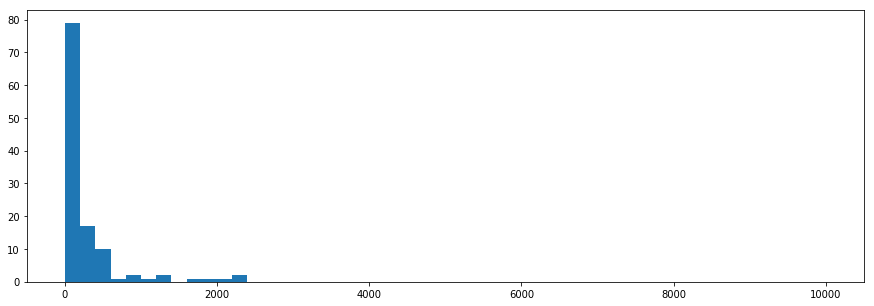

groupB


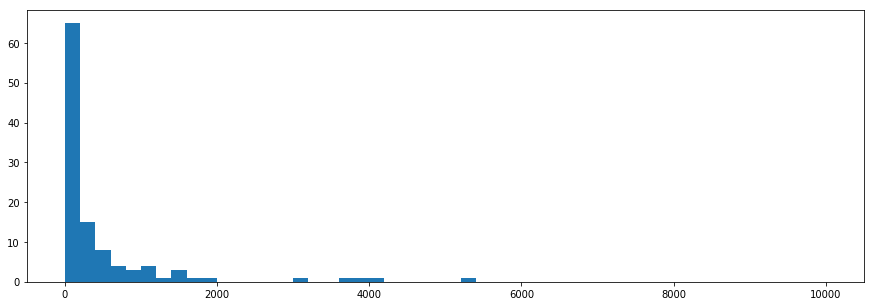

meanA: 374.02 meanB: 448.76
nA: 118 nB: 110 mw: 5968.0 z: -1.05 mw_pvalue: 0.15
insignificant

TRIAL
groupA


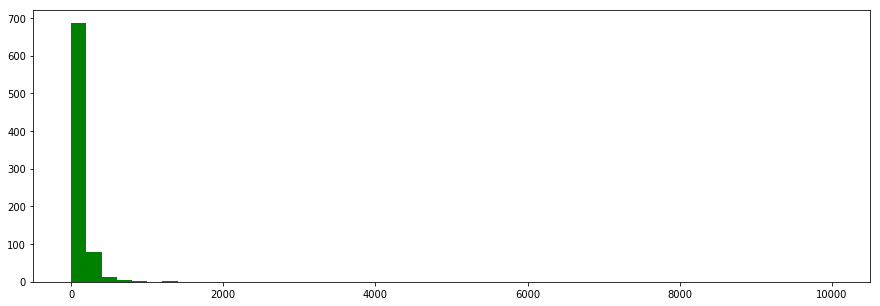

groupB


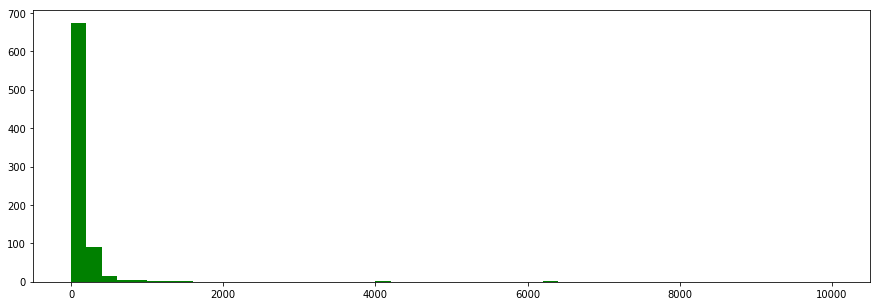

meanA: 95.51 meanB: 125.54
nA: 789 nB: 797 mw: 284373.0 z: -3.29 mw_pvalue: 0.0
significant
TOTAL
groupA


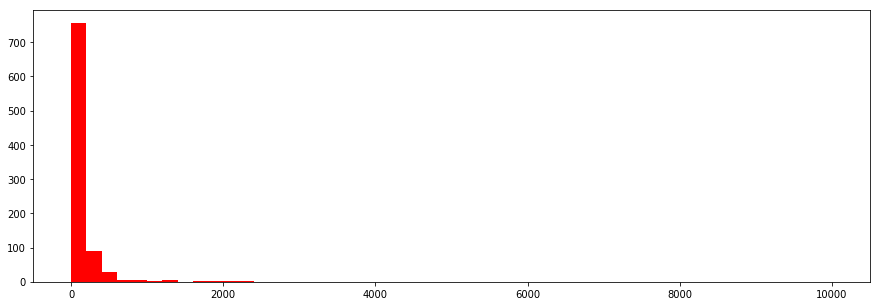

groupB


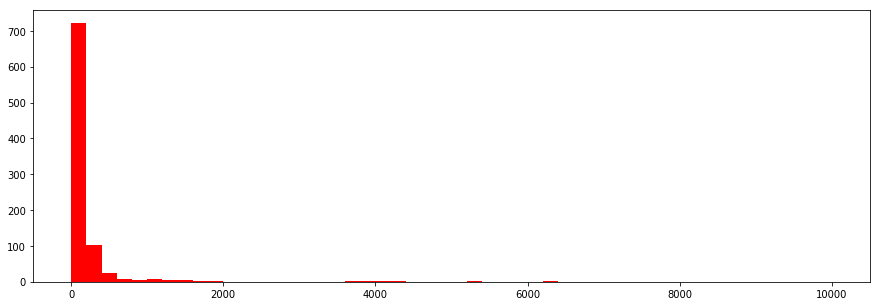

meanA: 133.36 meanB: 168.64
nA: 896 nB: 886 mw: 361546.5 z: -3.26 mw_pvalue: 0.0
significant


In [8]:
q = """
SELECT 
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
     billing_account_id,
     sum(trial_consumption) as trial,
     sum(real_consumption) as paid
FROM
     "//home/cloud_analytics/cubes/acquisition_cube/cube" as a GLOBAL INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as b 
USING puid
WHERE 
    event = 'day_use'
    and ba_usage_status != 'service'
    and toDate(event_time)>='2019-11-01'
    and sku_lazy = 0
    and service_name = 'compute'
    and subservice_name = 'cpu' 
    and segment = 'mass'
GROUP BY 
    group,
    billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'trial', 'paid'])

print 'PAID'
df1 = df[(df['group'] == 'groupA') & (df['paid'] > 0)]['paid'] 
df2 = df[(df['group'] == 'groupB') & (df['paid'] > 0)]['paid']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,10000))
plt.show()


n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print ''

print 'TRIAL'
df1 = df[(df['group'] == 'groupA') & (df['trial'] > 0)]['trial'] 
df2 = df[(df['group'] == 'groupB') & (df['trial'] > 0)]['trial']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'green')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'green')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print 'TOTAL'
df1 = df[(df['group'] == 'groupA')]['trial'] + df[(df['group'] == 'groupA')]['paid']
df2 = df[(df['group'] == 'groupB')]['trial'] + df[(df['group'] == 'groupB')]['paid']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'red')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'red')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# Compute CPU 5%

PAID
groupA


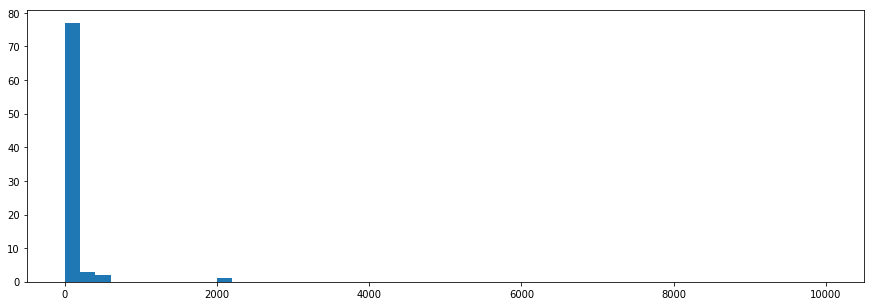

groupB


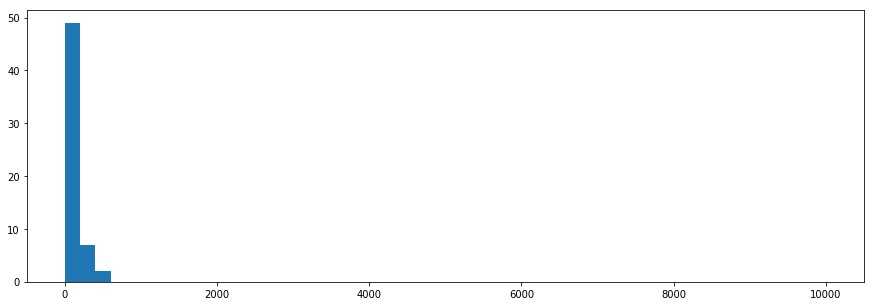

meanA: 85.51 meanB: 70.1
nA: 83 nB: 58 mw: 2474.0 z: 0.28 mw_pvalue: 0.61
insignificant

TRIAL
groupA


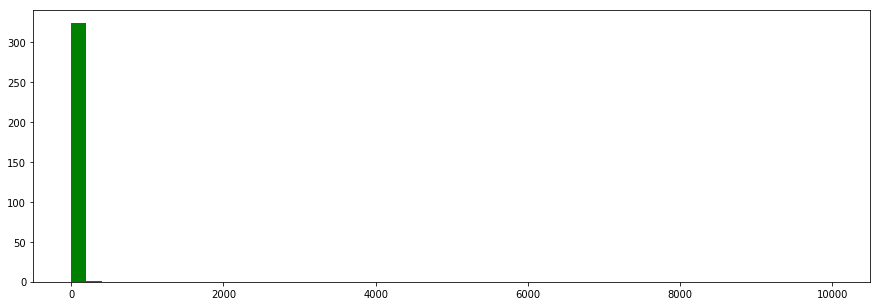

groupB


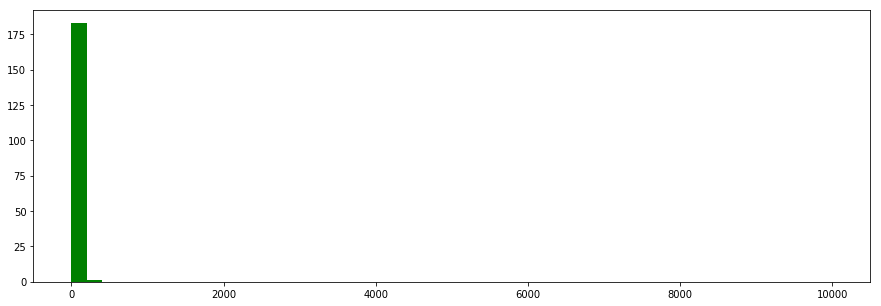

meanA: 25.39 meanB: 28.11
nA: 325 nB: 184 mw: 28720.5 z: -0.74 mw_pvalue: 0.23
insignificant
TOTAL
groupA


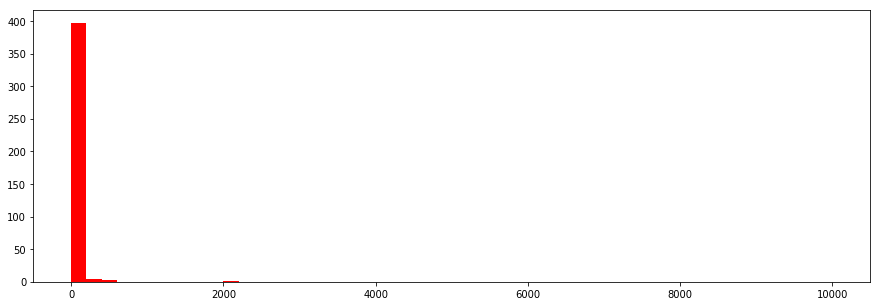

groupB


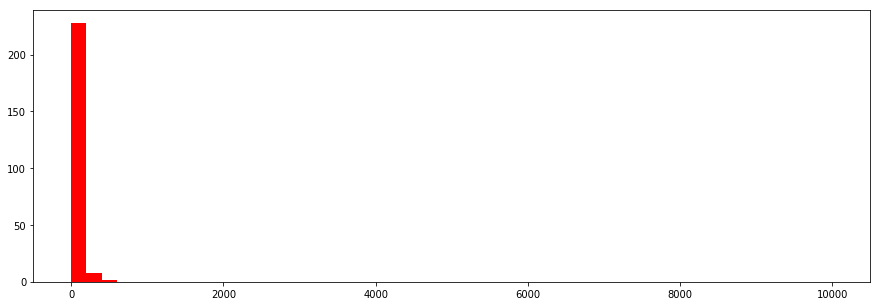

meanA: 37.99 meanB: 38.82
nA: 404 nB: 238 mw: 46725.0 z: -0.6 mw_pvalue: 0.28
insignificant


In [9]:
q = """
SELECT 
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
     billing_account_id,
     sum(trial_consumption) as trial,
     sum(real_consumption) as paid
FROM
     "//home/cloud_analytics/cubes/acquisition_cube/cube" as a GLOBAL INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as b 
USING puid
WHERE 
    event = 'day_use'
    and ba_usage_status != 'service'
    and toDate(event_time)>='2019-11-01'
    and sku_lazy = 0
    and service_name = 'compute'
    and subservice_name = 'cpu' 
    and core_fraction = '5'
    and segment = 'mass'
GROUP BY 
    group,
    billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'trial', 'paid'])

print 'PAID'
df1 = df[(df['group'] == 'groupA') & (df['paid'] > 0)]['paid'] 
df2 = df[(df['group'] == 'groupB') & (df['paid'] > 0)]['paid']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,10000))
plt.show()


n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print ''

print 'TRIAL'
df1 = df[(df['group'] == 'groupA') & (df['trial'] > 0)]['trial'] 
df2 = df[(df['group'] == 'groupB') & (df['trial'] > 0)]['trial']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'green')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'green')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print 'TOTAL'
df1 = df[(df['group'] == 'groupA')]['trial'] + df[(df['group'] == 'groupA')]['paid']
df2 = df[(df['group'] == 'groupB')]['trial'] + df[(df['group'] == 'groupB')]['paid']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'red')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'red')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# Compute CPU 20%

PAID
groupA


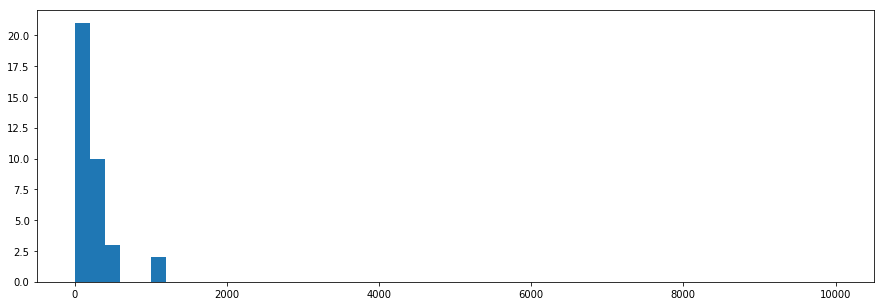

groupB


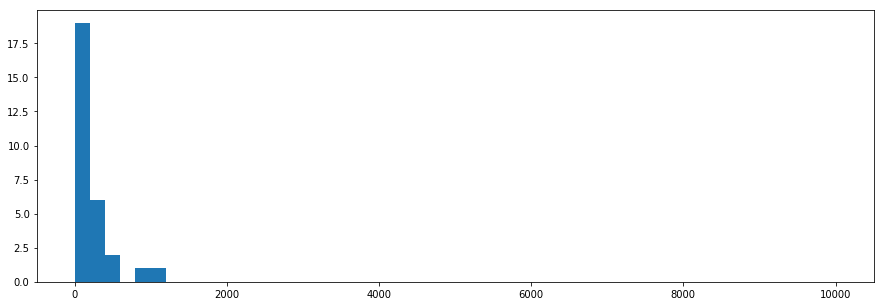

meanA: 187.14 meanB: 169.82
nA: 36 nB: 29 mw: 556.0 z: 0.45 mw_pvalue: 0.68
insignificant

TRIAL
groupA


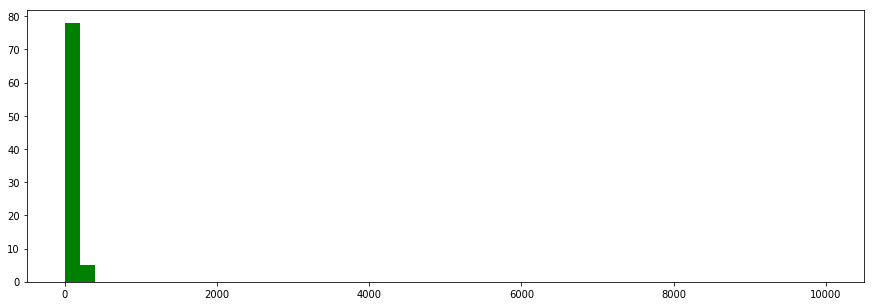

groupB


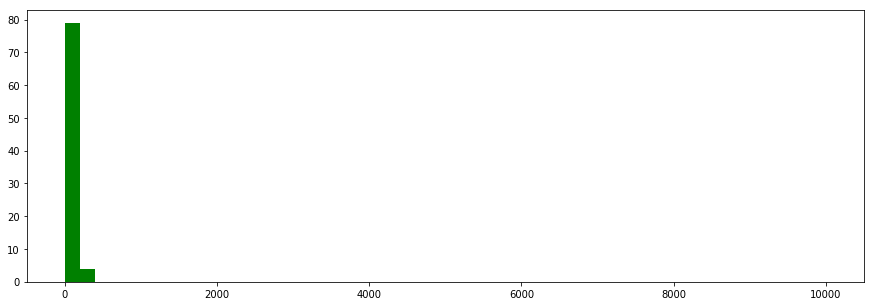

meanA: 56.16 meanB: 58.41
nA: 83 nB: 83 mw: 3170.0 z: -0.88 mw_pvalue: 0.19
insignificant
TOTAL
groupA


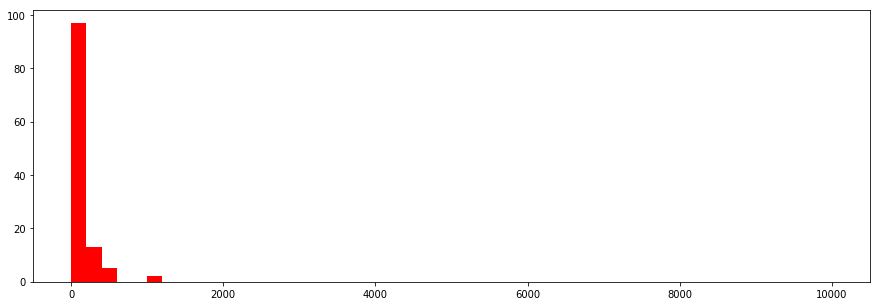

groupB


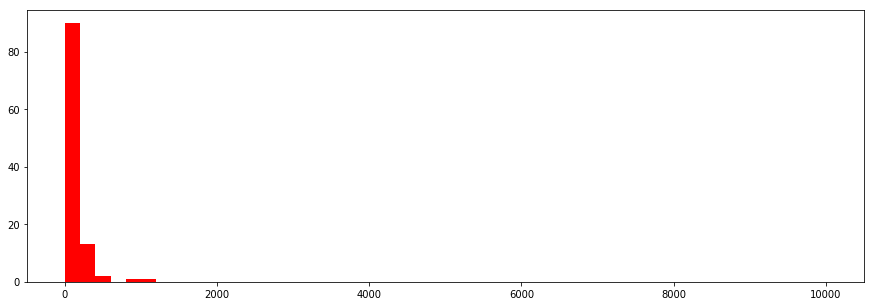

meanA: 97.42 meanB: 91.34
nA: 117 nB: 107 mw: 6100.0 z: -0.33 mw_pvalue: 0.37
insignificant


In [10]:
q = """
SELECT 
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
     billing_account_id,
     sum(trial_consumption) as trial,
     sum(real_consumption) as paid
FROM
     "//home/cloud_analytics/cubes/acquisition_cube/cube" as a GLOBAL INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as b 
USING puid
WHERE 
    event = 'day_use'
    and ba_usage_status != 'service'
    and toDate(event_time)>='2019-11-01'
    and sku_lazy = 0
    and service_name = 'compute'
    and subservice_name = 'cpu' 
    and core_fraction = '20'
    and segment = 'mass'
GROUP BY 
    group,
    billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'trial', 'paid'])

print 'PAID'
df1 = df[(df['group'] == 'groupA') & (df['paid'] > 0)]['paid'] 
df2 = df[(df['group'] == 'groupB') & (df['paid'] > 0)]['paid']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,10000))
plt.show()


n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print ''

print 'TRIAL'
df1 = df[(df['group'] == 'groupA') & (df['trial'] > 0)]['trial'] 
df2 = df[(df['group'] == 'groupB') & (df['trial'] > 0)]['trial']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'green')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'green')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print 'TOTAL'
df1 = df[(df['group'] == 'groupA')]['trial'] + df[(df['group'] == 'groupA')]['paid']
df2 = df[(df['group'] == 'groupB')]['trial'] + df[(df['group'] == 'groupB')]['paid']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'red')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'red')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# Compute CPU 50%

PAID
groupA


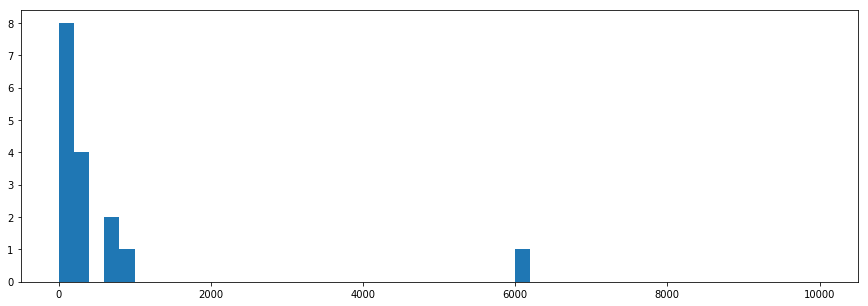

groupB


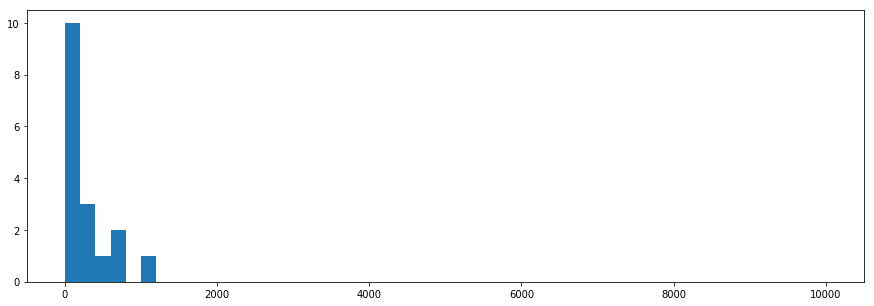

meanA: 631.28 meanB: 242.53
nA: 16 nB: 17 mw: 148.0 z: 0.43 mw_pvalue: 0.67
insignificant

TRIAL
groupA


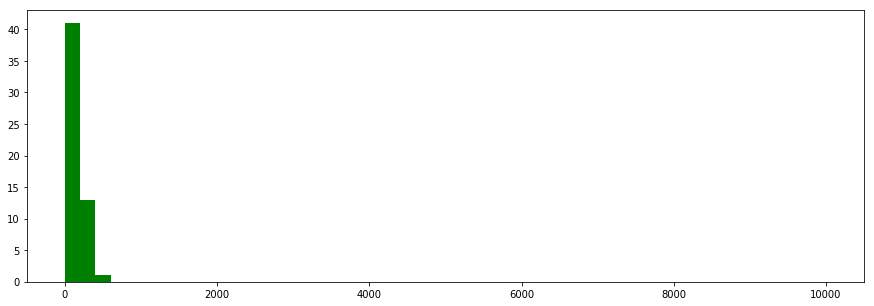

groupB


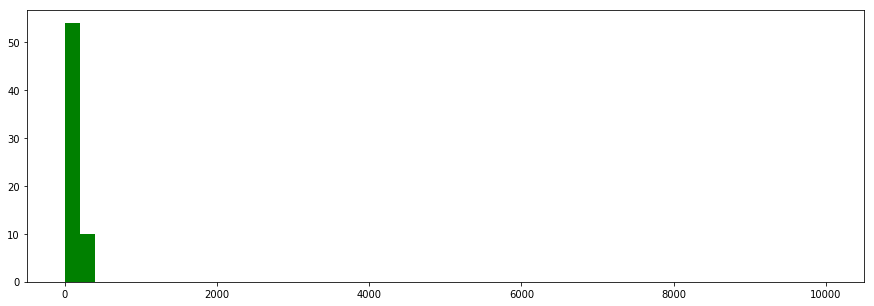

meanA: 103.72 meanB: 81.07
nA: 55 nB: 64 mw: 1992.0 z: 1.24 mw_pvalue: 0.89
insignificant
TOTAL
groupA


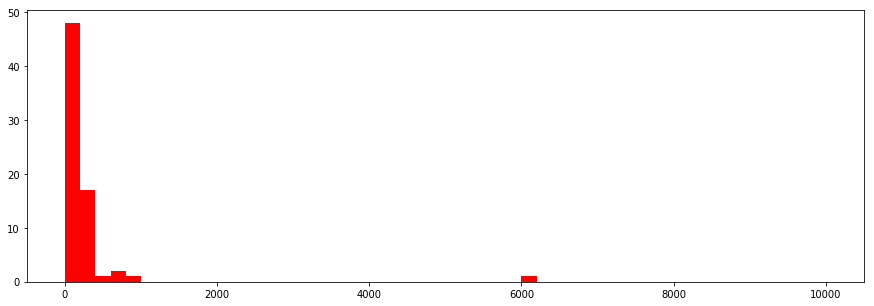

groupB


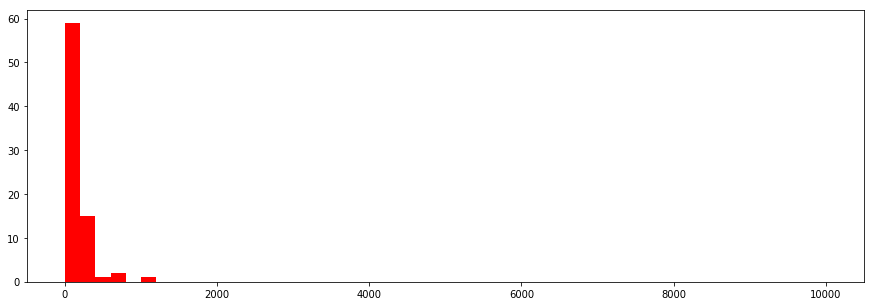

meanA: 225.79 meanB: 119.38
nA: 70 nB: 78 mw: 3050.0 z: 1.23 mw_pvalue: 0.89
insignificant


In [11]:
q = """
SELECT 
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
     billing_account_id,
     sum(trial_consumption) as trial,
     sum(real_consumption) as paid
FROM
     "//home/cloud_analytics/cubes/acquisition_cube/cube" as a GLOBAL INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as b 
USING puid
WHERE 
    event = 'day_use'
    and ba_usage_status != 'service'
    and toDate(event_time)>='2019-11-01'
    and sku_lazy = 0
    and service_name = 'compute'
    and subservice_name = 'cpu' 
    and core_fraction = '50'
    and segment = 'mass'
GROUP BY 
    group,
    billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'trial', 'paid'])

print 'PAID'
df1 = df[(df['group'] == 'groupA') & (df['paid'] > 0)]['paid'] 
df2 = df[(df['group'] == 'groupB') & (df['paid'] > 0)]['paid']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,10000))
plt.show()


n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print ''

print 'TRIAL'
df1 = df[(df['group'] == 'groupA') & (df['trial'] > 0)]['trial'] 
df2 = df[(df['group'] == 'groupB') & (df['trial'] > 0)]['trial']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'green')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'green')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print 'TOTAL'
df1 = df[(df['group'] == 'groupA')]['trial'] + df[(df['group'] == 'groupA')]['paid']
df2 = df[(df['group'] == 'groupB')]['trial'] + df[(df['group'] == 'groupB')]['paid']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'red')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'red')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# Compute CPU 100%

PAID
groupA


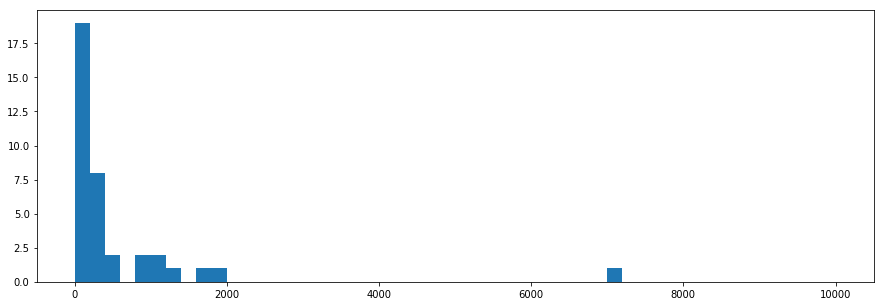

groupB


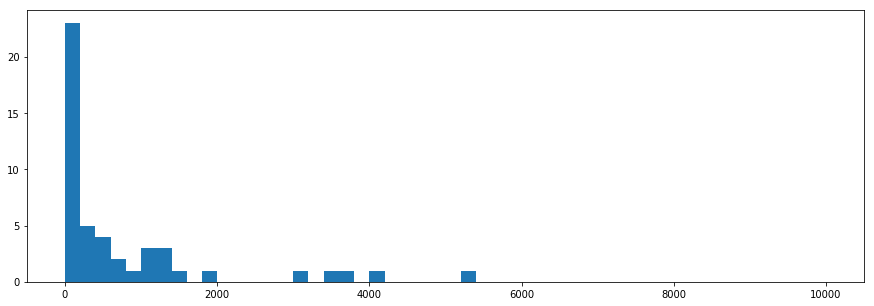

meanA: 545.91 meanB: 755.2
nA: 37 nB: 48 mw: 815.0 z: -0.65 mw_pvalue: 0.26
insignificant

TRIAL
groupA


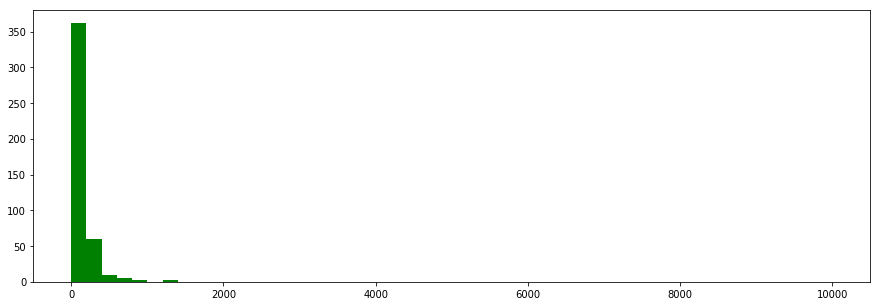

groupB


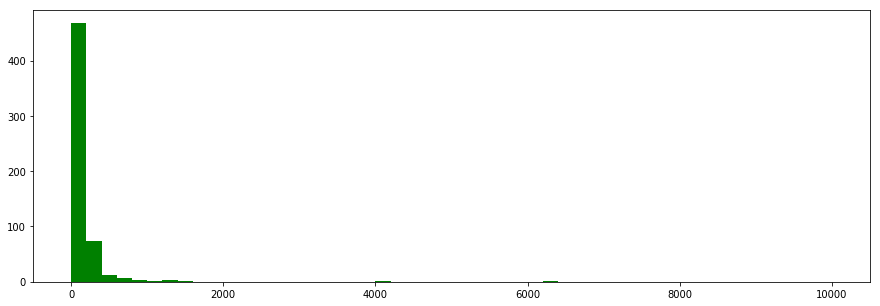

meanA: 128.37 meanB: 148.33
nA: 442 nB: 572 mw: 129160.5 z: 0.59 mw_pvalue: 0.72
insignificant
TOTAL
groupA


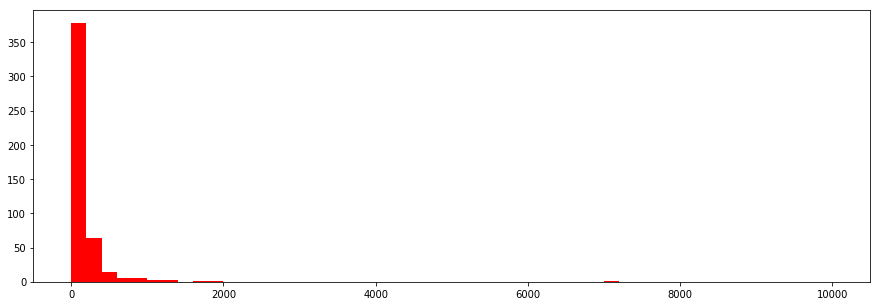

groupB


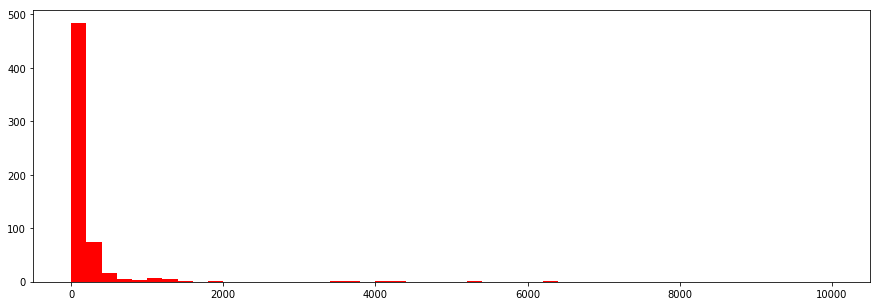

meanA: 161.98 meanB: 199.5
nA: 475 nB: 607 mw: 145866.5 z: 0.33 mw_pvalue: 0.63
insignificant


In [12]:
q = """
SELECT 
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
     billing_account_id,
     sum(trial_consumption) as trial,
     sum(real_consumption) as paid
FROM
     "//home/cloud_analytics/cubes/acquisition_cube/cube" as a GLOBAL INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as b 
USING puid
WHERE 
    event = 'day_use'
    and ba_usage_status != 'service'
    and toDate(event_time)>='2019-11-01'
    and sku_lazy = 0
    and service_name = 'compute'
    and subservice_name = 'cpu' 
    and core_fraction = '100'
    and segment = 'mass'
GROUP BY 
    group,
    billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'trial', 'paid'])

print 'PAID'
df1 = df[(df['group'] == 'groupA') & (df['paid'] > 0)]['paid'] 
df2 = df[(df['group'] == 'groupB') & (df['paid'] > 0)]['paid']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,10000))
plt.show()


n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print ''

print 'TRIAL'
df1 = df[(df['group'] == 'groupA') & (df['trial'] > 0)]['trial'] 
df2 = df[(df['group'] == 'groupB') & (df['trial'] > 0)]['trial']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'green')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'green')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print 'TOTAL'
df1 = df[(df['group'] == 'groupA')]['trial'] + df[(df['group'] == 'groupA')]['paid']
df2 = df[(df['group'] == 'groupB')]['trial'] + df[(df['group'] == 'groupB')]['paid']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'red')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'red')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# Compute CPU higher than 5%

PAID
groupA


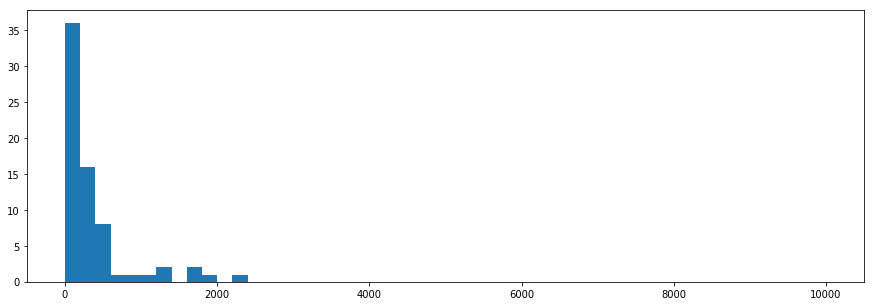

groupB


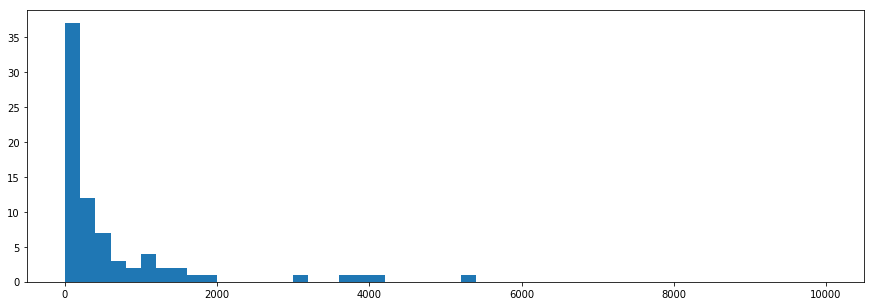

meanA: 529.09 meanB: 596.02
nA: 70 nB: 76 mw: 2451.0 z: -0.82 mw_pvalue: 0.21
insignificant

TRIAL
groupA


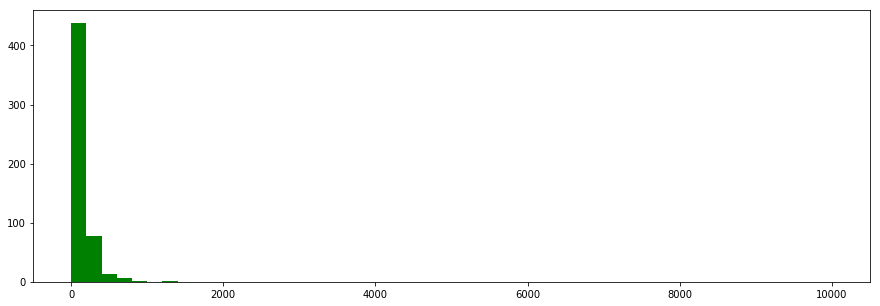

groupB


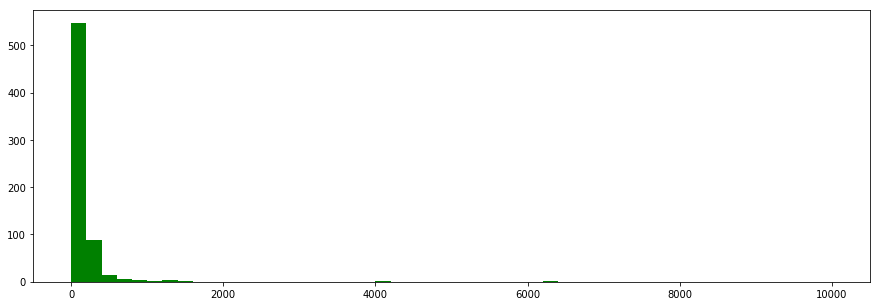

meanA: 124.5 meanB: 142.04
nA: 539 nB: 668 mw: 180566.5 z: 0.09 mw_pvalue: 0.54
insignificant
TOTAL
groupA


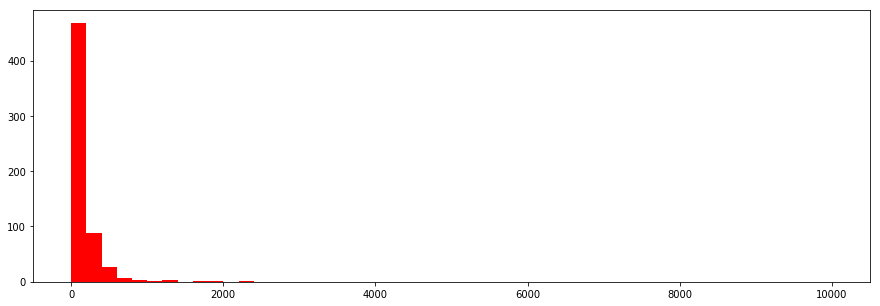

groupB


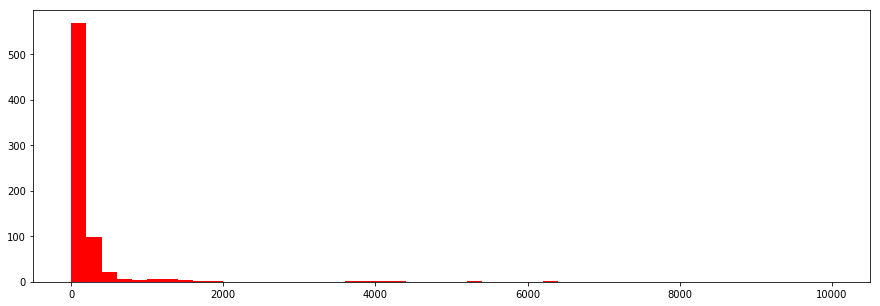

meanA: 172.99 meanB: 193.35
nA: 602 nB: 725 mw: 217757.5 z: -0.07 mw_pvalue: 0.47
insignificant


In [13]:
q = """
SELECT 
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
     billing_account_id,
     sum(trial_consumption) as trial,
     sum(real_consumption) as paid
FROM
     "//home/cloud_analytics/cubes/acquisition_cube/cube" as a GLOBAL INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as b 
USING puid
WHERE 
    event = 'day_use'
    and ba_usage_status != 'service'
    and toDate(event_time)>='2019-11-01'
    and sku_lazy = 0
    and service_name = 'compute'
    and subservice_name = 'cpu' 
    and core_fraction != '5'
    and segment = 'mass'
GROUP BY 
    group,
    billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'trial', 'paid'])

print 'PAID'
df1 = df[(df['group'] == 'groupA') & (df['paid'] > 0)]['paid'] 
df2 = df[(df['group'] == 'groupB') & (df['paid'] > 0)]['paid']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,10000))
plt.show()


n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print ''

print 'TRIAL'
df1 = df[(df['group'] == 'groupA') & (df['trial'] > 0)]['trial'] 
df2 = df[(df['group'] == 'groupB') & (df['trial'] > 0)]['trial']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'green')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'green')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

print 'TOTAL'
df1 = df[(df['group'] == 'groupA')]['trial'] + df[(df['group'] == 'groupA')]['paid']
df2 = df[(df['group'] == 'groupB')]['trial'] + df[(df['group'] == 'groupB')]['paid']


print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,10000), color = 'red')
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50, range=(0,10000), color = 'red')
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# VM Count

groupA


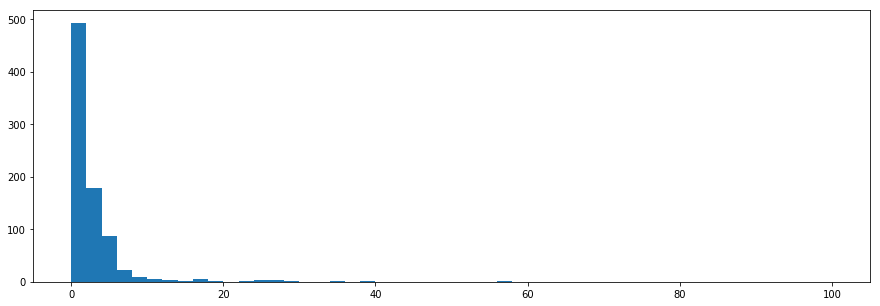

groupB


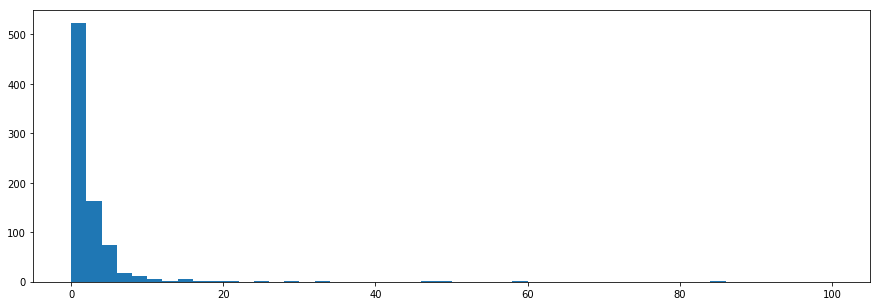

meanA: 2.55 meanB: 3.38
nA: 822 nB: 818 mw: 348164.0 z: 1.25 mw_pvalue: 0.92
insignificant


In [14]:
q = """
SELECT
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
billing_account_id,
count(resource_id) as vm_count
FROM (

SELECT
    resource_id,
    core_fraction,
    start_d,
    billing_account_id,
    puid
FROM (
SELECT DISTINCT
    resource_id,
    core_fraction,
    toDate(start) as start_d,
    billing_account_id,
    puid
FROM
  "//home/cloud_analytics/tmp/artkaz/compute_logs/agg" as a INNER JOIN (
    SELECT 
        billing_account_id, 
        argMax(puid, event_time) as puid
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    GROUP BY billing_account_id
        ) as b 
    USING billing_account_id
WHERE start_d >= '2019-11-01' and ba_usage_status != 'service'
) as c 
INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as d 
USING puid
    
)
GROUP by group, billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'vm_count'])


df1 = df[df['group'] == 'groupA']['vm_count'] 
df2 = df[df['group'] == 'groupB']['vm_count']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,100))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,100))
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'


# VM Count - 5%

groupA


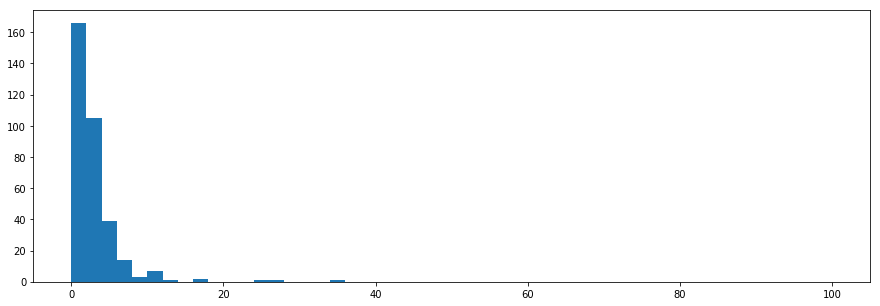

groupB


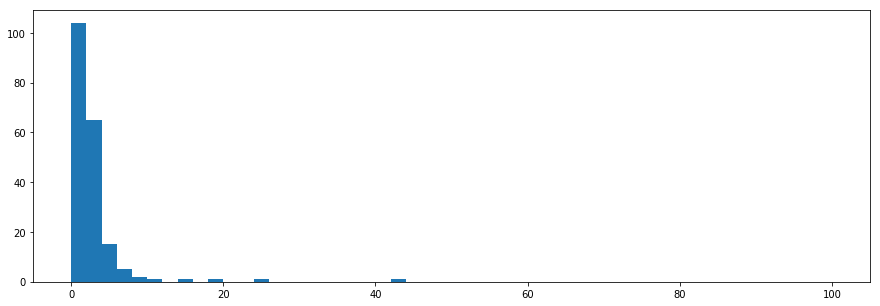

meanA: 2.62 meanB: 2.97
nA: 340 nB: 197 mw: 35312.5 z: 1.05 mw_pvalue: 0.87
insignificant


In [15]:
q = """
SELECT
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
billing_account_id,
count(resource_id) as vm_count
FROM (

SELECT
    resource_id,
    core_fraction,
    start_d,
    billing_account_id,
    puid
FROM (
SELECT DISTINCT
    resource_id,
    core_fraction,
    toDate(start) as start_d,
    billing_account_id,
    puid
FROM
  "//home/cloud_analytics/tmp/artkaz/compute_logs/agg" as a INNER JOIN (
    SELECT 
        billing_account_id, 
        argMax(puid, event_time) as puid
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    GROUP BY billing_account_id
        ) as b 
    USING billing_account_id
WHERE start_d >= '2019-11-01' and core_fraction = 5 and ba_usage_status != 'service'
) as c 
INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as d 
USING puid
    
)
GROUP by group, billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'vm_count'])

df1 = df[df['group'] == 'groupA']['vm_count'] 
df2 = df[df['group'] == 'groupB']['vm_count']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,100))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,100))
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# VM Count - 20%

groupA


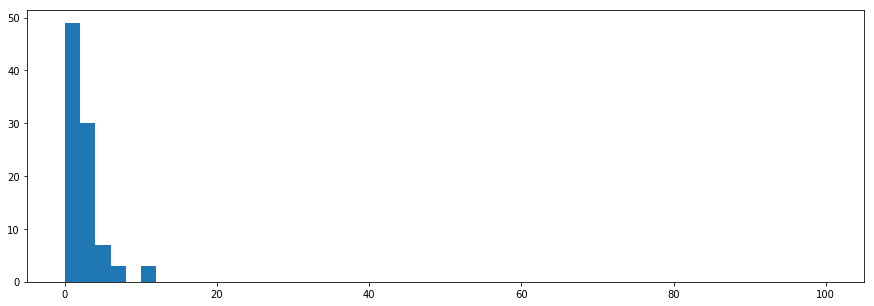

groupB


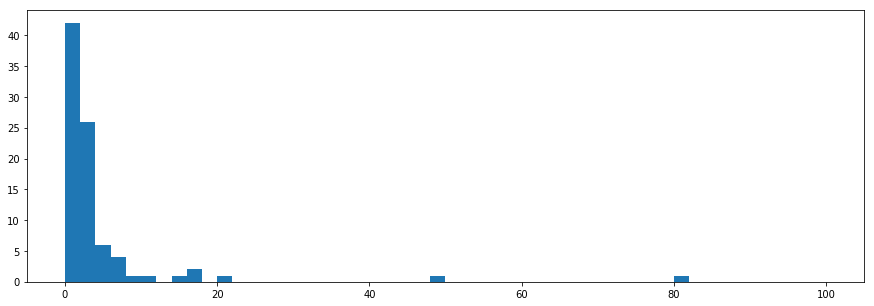

meanA: 2.11 meanB: 4.28
nA: 92 nB: 86 mw: 3594.5 z: -1.05 mw_pvalue: 0.13
insignificant


In [5]:
q = """
SELECT
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
billing_account_id,
count(resource_id) as vm_count
FROM (

SELECT
    resource_id,
    core_fraction,
    start_d,
    billing_account_id,
    puid
FROM (
SELECT DISTINCT
    resource_id,
    core_fraction,
    toDate(start) as start_d,
    billing_account_id,
    puid
FROM
  "//home/cloud_analytics/tmp/artkaz/compute_logs/agg" as a INNER JOIN (
    SELECT 
        billing_account_id, 
        argMax(puid, event_time) as puid
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    GROUP BY billing_account_id
        ) as b 
    USING billing_account_id
WHERE start_d >= '2019-11-01' and core_fraction = 20 and ba_usage_status != 'service'
) as c 
INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01' 
    ) as d 
USING puid
    
)
GROUP by group, billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'vm_count'])


df1 = df[df['group'] == 'groupA']['vm_count'] 
df2 = df[df['group'] == 'groupB']['vm_count']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,100))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,100))
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'


# VM Count - 50%

groupA


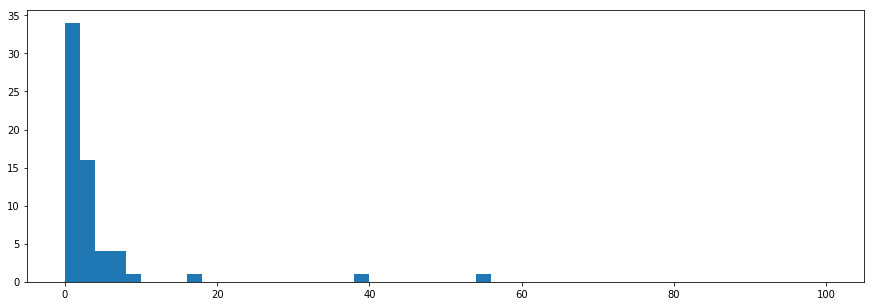

groupB


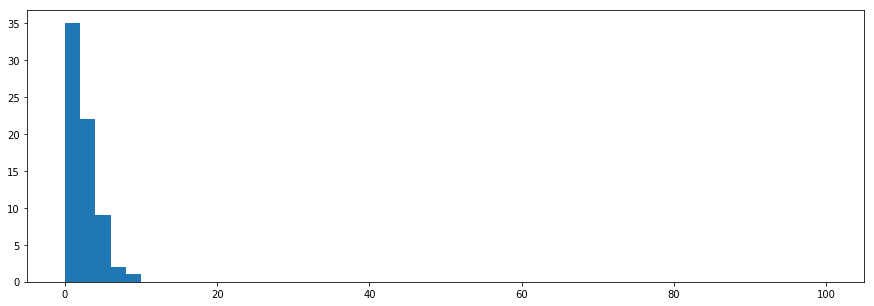

meanA: 3.77 meanB: 2.14
nA: 62 nB: 69 mw: 2132.5 z: -0.03 mw_pvalue: 0.49
insignificant


In [6]:
q = """
SELECT
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
billing_account_id,
count(resource_id) as vm_count
FROM (

SELECT
    resource_id,
    core_fraction,
    start_d,
    billing_account_id,
    puid
FROM (
SELECT DISTINCT
    resource_id,
    core_fraction,
    toDate(start) as start_d,
    billing_account_id,
    puid
FROM
  "//home/cloud_analytics/tmp/artkaz/compute_logs/agg" as a INNER JOIN (
    SELECT 
        billing_account_id, 
        argMax(puid, event_time) as puid
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    GROUP BY billing_account_id
        ) as b 
    USING billing_account_id
WHERE start_d >= '2019-11-01' and core_fraction = 50 and ba_usage_status != 'service'
) as c 
INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as d 
USING puid
    
)
GROUP by group, billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'vm_count'])


df1 = df[df['group'] == 'groupA']['vm_count'] 
df2 = df[df['group'] == 'groupB']['vm_count']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,100))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,100))
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'


# VM Count - 100%

groupA


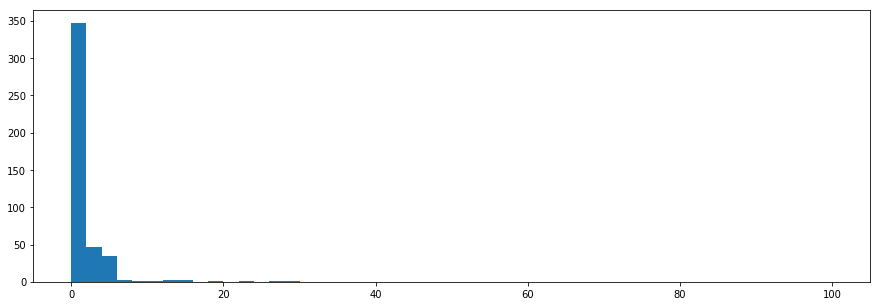

groupB


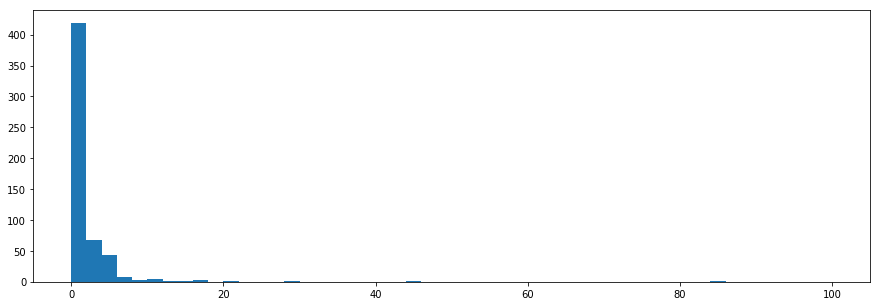

meanA: 1.76 meanB: 2.99
nA: 440 nB: 555 mw: 117532.0 z: -1.01 mw_pvalue: 0.08
insignificant


In [7]:
q = """
SELECT
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
billing_account_id,
count(resource_id) as vm_count
FROM (

SELECT
    resource_id,
    core_fraction,
    start_d,
    billing_account_id,
    puid
FROM (
SELECT DISTINCT
    resource_id,
    core_fraction,
    toDate(start) as start_d,
    billing_account_id,
    puid
FROM
  "//home/cloud_analytics/tmp/artkaz/compute_logs/agg" as a INNER JOIN (
    SELECT 
        billing_account_id, 
        argMax(puid, event_time) as puid
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    GROUP BY billing_account_id
        ) as b 
    USING billing_account_id
WHERE start_d >= '2019-11-01' and core_fraction = 100 and ba_usage_status != 'service'
) as c 
INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as d 
USING puid
    
)
GROUP by group, billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'vm_count'])


df1 = df[df['group'] == 'groupA']['vm_count'] 
df2 = df[df['group'] == 'groupB']['vm_count']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,100))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,100))
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

# VM Count - not 5%

groupA


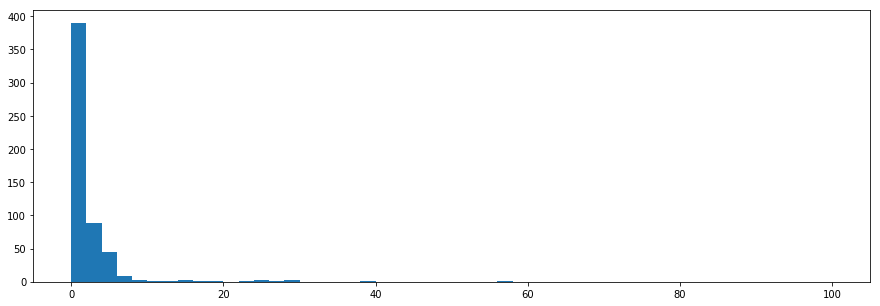

groupB


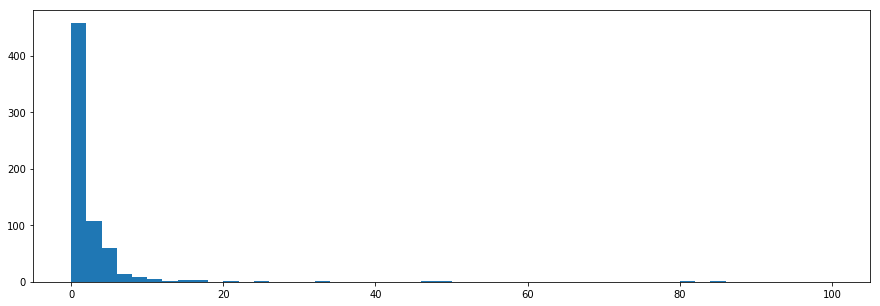

meanA: 2.19 meanB: 3.26
nA: 549 nB: 668 mw: 177504.0 z: -0.96 mw_pvalue: 0.12
insignificant


In [8]:
q = """
SELECT
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,
billing_account_id,
count(resource_id) as vm_count
FROM (

SELECT
    resource_id,
    core_fraction,
    start_d,
    billing_account_id,
    puid
FROM (
SELECT DISTINCT
    resource_id,
    core_fraction,
    toDate(start) as start_d,
    billing_account_id,
    puid
FROM
  "//home/cloud_analytics/tmp/artkaz/compute_logs/agg" as a INNER JOIN (
    SELECT 
        billing_account_id, 
        argMax(puid, event_time) as puid
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    GROUP BY billing_account_id
        ) as b 
    USING billing_account_id
WHERE start_d >= '2019-11-01' and core_fraction > 5 and ba_usage_status != 'service'
) as c 
INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as d 
USING puid
    
)
GROUP by group, billing_account_id
"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['group', 'billing_account_id', 'vm_count'])

df1 = df[df['group'] == 'groupA']['vm_count'] 
df2 = df[df['group'] == 'groupB']['vm_count']

print 'groupA'
plt.figure(figsize=(15,5))
plt.hist(df1, bins = 50, range=(0,100))
plt.show()

print 'groupB'
plt.figure(figsize=(15,5))
plt.hist(df2, bins = 50 , range=(0,100))
plt.show()

n1 = df1.shape[0]
n2 = df2.shape[0]

mw, mw_pvalue = mannwhitneyu(df1.values, 
                             df2.values, 
                             alternative='less')

print 'meanA:', round(df1.mean(),2), \
      'meanB:', round(df2.mean(),2)

print 'nA:', n1, 'nB:', n2, 'mw:', mw, \
      'z:', round((mw - (n1*n2/2) ) / (np.sqrt(n1*n2*(n1+n2+1)/12)),2),  'mw_pvalue:', round(mw_pvalue,2)

print 'insignificant' if mw_pvalue > .05 else 'significant'

In [9]:
q = """SELECT
core_fraction,
     if(toInt64(substring(puid,length(puid), 1))%2=1, 'groupA', 'groupB') as group,

count(resource_id) as vm_count
FROM (

SELECT
    resource_id,
    core_fraction,
    start_d,
    billing_account_id,
    puid
FROM (
SELECT DISTINCT
    resource_id,
    core_fraction,
    toDate(start) as start_d,
    billing_account_id,
    puid
FROM
  "//home/cloud_analytics/tmp/artkaz/compute_logs/agg" as a LEFT JOIN (
    SELECT 
        billing_account_id, 
        argMax(puid, event_time) as puid
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    GROUP BY billing_account_id
        ) as b 
    USING billing_account_id
WHERE start_d >= '2019-11-01' and ba_usage_status != 'service' and segment = 'mass'--and core_fraction = 5
) as c 
INNER JOIN (
    SELECT DISTINCT
        puid
    FROM "//home/cloud_analytics/import/console_logs/events"
    WHERE
        (event LIKE '%create-instance%' )
        AND puid != '' AND toDate(toDateTime(toInt64(ts))) >= '2019-11-01'
    ) as d 
USING puid
    
)
GROUP by group,core_fraction
ORDER BY core_fraction, group"""

res = execute_query(q)
df = pd.read_csv(StringIO(res), sep ='\t', names=['core_fraction', 'group', 'vm_count'])

In [28]:
df.pivot_table(columns=['group'], index=['core_fraction'], values=['vm_count'], aggfunc='sum').reset_index().sum()

               group 
core_fraction             175
vm_count       groupA    2000
               groupB    2027
dtype: int64

In [27]:
print ('#|')
for r in df.pivot_table(columns=['group'], index=['core_fraction'], values=['vm_count'], aggfunc='sum').reset_index().values:
    s = '||'
    for c in r:
        s+= str(c) + '|'
    s+= '|'
    print s
print ('|#')

#|
||5|869|562||
||20|186|359||
||50|228|136||
||100|717|970||
|#
